In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pathlib
import numpy as np
from anndata import AnnData

%load_ext autoreload
%autoreload 2
%load_ext lab_black

sc.logging.print_header()

scanpy==1.7.0rc2.dev1+g2a123065 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.5.2 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.2


In [2]:
BASE_PATH = pathlib.Path(
    "/Users/giovanni.palla/dataset_raw_icb/20201214_SquidpyData_giovanni.palla"
)
DATA_PATH = "scMouseCortex"

In [3]:
counts = pd.read_csv(
    BASE_PATH / DATA_PATH / "GSE115746_cells_exon_counts.csv.gz", index_col=0
)
counts_t = counts.T.copy()

In [4]:
metadata = pd.read_csv(
    BASE_PATH / DATA_PATH / "GSE115746_complete_metadata_28706-cells.csv.gz"
)

In [5]:
metadata = metadata[
    [
        "sample_name",
        "organism",
        "donor_sex",
        "cell_class",
        "cell_subclass",
        "cell_cluster",
    ]
].copy()
metadata = metadata[metadata.sample_name.isin(counts_t.index.values)].copy()
metadata.index = metadata.sample_name
metadata = metadata.reindex(counts_t.index)

In [6]:
np.testing.assert_array_equal(metadata.sample_name.values, counts_t.index.values)

In [34]:
from scipy import sparse

adata_raw = AnnData(sparse.csr_matrix(counts_t.to_numpy()), obs=metadata)
adata_raw.var_names_make_unique()
adata_raw.var["mt"] = adata_raw.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_raw, qc_vars=["mt"], inplace=True)

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

<AxesSubplot:xlabel='n_genes_by_counts'>

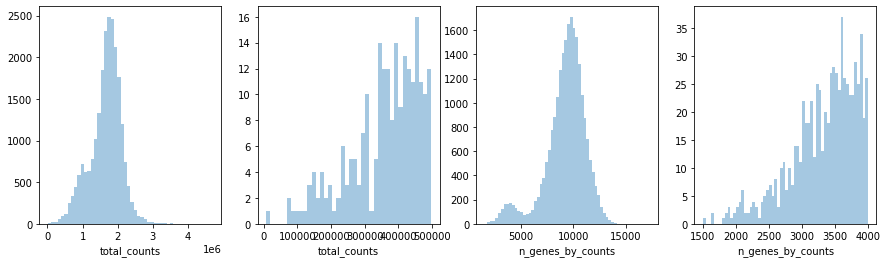

In [41]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata_raw.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(
    adata_raw.obs["total_counts"][adata_raw.obs["total_counts"] < 500000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.distplot(adata_raw.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(
    adata_raw.obs["n_genes_by_counts"][adata_raw.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [42]:
sc.pp.filter_cells(adata_raw, min_counts=500000)
sc.pp.filter_genes(adata_raw, min_cells=10)

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [43]:
adata_raw.obs.cell_subclass.value_counts()

L5 IT             2952
Vip               2645
Sst               2534
L6 IT             2166
Pvalb             2065
Lamp5             1837
L4                1340
L6 CT             1220
L2/3 IT           1172
L5 PT              895
NP                 733
Astro              545
No Class           495
L6b                457
Sncg               244
Oligo              185
High Intronic      170
Endo               155
Low Quality        142
Batch Grouping     132
Macrophage         131
VLMC               131
SMC                106
Serpinf1            84
Doublet             83
Meis2               55
Peri                28
CR                  17
Name: cell_subclass, dtype: int64

In [44]:
adata_raw.shape

(22951, 36826)

In [45]:
adata = adata_raw[
    (~adata_raw.obs.cell_subclass.isnull())
    & (adata_raw.obs.cell_subclass != "No Class")
    & (adata_raw.obs.cell_class != "Low Quality")
].copy()
adata.shape

(21697, 36826)

In [46]:
adata.raw = adata
adata.obs.cell_class = adata.obs.cell_class.astype("category")
adata.obs.cell_subclass = adata.obs.cell_subclass.astype("category")
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/giovanni.palla/Projects/scanpy/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'organism' as categorical
... storing 'donor_sex' as categorical
... storing 'cell_cluster' as categorical


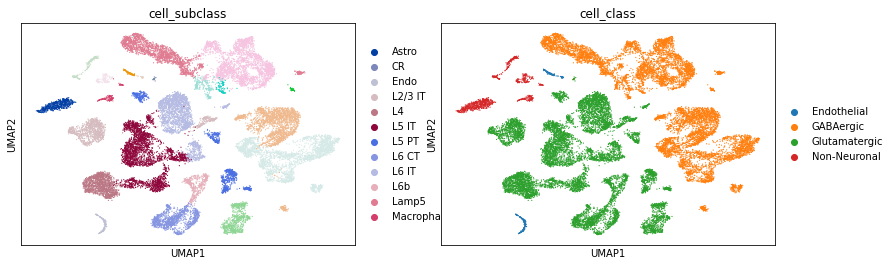

In [47]:
sc.pl.umap(adata, color=["cell_subclass", "cell_class"])

In [48]:
adata.write("/Users/giovanni.palla/Datasets/tutorial_data/sc_mouse_cortex.h5ad")